# My First Autoencoder

The purpose of this small project is not to develop some SOTA, ground-breaking autoencoder which is able to learn effective representations, but rather just to experiment a bit with what they are, what the architecture is, and what it gives.

At this point, I have not watched any videos or read any papers on autoencoders. However, I have seen rough diagrams of the design and this is what I'm trying to recreate.

## Imports

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('mps')

# Auxillary Functions

In [4]:
def printf(string, terminal = False):
    # function for printing stuff that gets removed from the output each iteration
    import sys
    if terminal:
        sys.stdout.write("\r")
        sys.stdout.write(string)
        sys.stdout.flush()
    else:
        from IPython.display import display, clear_output
        clear_output(wait = True)
        print(string, end = '')
        sys.stdout.flush()

## Transformations and Data

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

batch_size = 30

train_dataset = torchvision.datasets.MNIST('./torch_data', train = True, transform = transform, download = True)
test_dataset = torchvision.datasets.MNIST('./torch_data', train = False, transform = transform, download = True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

100.0%


Extracting ./torch_data/MNIST/raw/train-images-idx3-ubyte.gz to ./torch_data/MNIST/raw



100.0%


Extracting ./torch_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./torch_data/MNIST/raw



100.0%


Extracting ./torch_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./torch_data/MNIST/raw



100.0%

Extracting ./torch_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./torch_data/MNIST/raw



## Model

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, batch_size):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(28 * 28, 588)
        self.bn1 = nn.BatchNorm1d(588)
        self.fc2 = nn.Linear(588, 441)
        self.bn2 = nn.BatchNorm1d(441)
        
        # Decoder
        self.fc3 = nn.Linear(441, 588)
        self.bn3 = nn.BatchNorm1d(588)
        self.fc4 = nn.Linear(588, 28 * 28)
        self.bn4 = nn.BatchNorm1d(28 * 28)
        
        self.activation = nn.ReLU()
        self.batch_size = batch_size
    
    def encode(self, x):
        '''
        Takes input and passes it through two fully-connected 
        layers with batch normalisation and relu applied.
        '''
        x = x.reshape(batch_size, -1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        return x
    
    def decode(self, x):
        '''
        Same as the encoder.
        '''
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.activation(x)
        x = x.reshape(batch_size, 1, 28, 28)
        return x
    
    def forward(self, x, encode = False, decode = False):
        if encode:
            return self.encode(x).reshape(batch_size, 1, 21, 21)
        if decode:
            return self.decode(x)
        x = self.encode(x)
        x = self.decode(x)
        return x

## Training

In [7]:
model = Autoencoder(batch_size).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [8]:
losses = []
avg_losses = []

n_epochs = 50
for epoch in range(n_epochs):
    epoch_loss = 0
    for f, _ in train_loader:
        f = f.to(device)
        
        # Forward pass
        outputs = model(f)
        loss = nn.MSELoss()(f, outputs)
        epoch_loss += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    printf(f'Epoch: {epoch}, Epoch Loss: {epoch_loss:.4f}, Avg Loss: {epoch_loss / len(train_loader):.4f}')
    
    # Keeping track of the loss values
    losses.append(epoch_loss)
    avg_losses.append(epoch_loss / len(train_loader))

Epoch: 49, Epoch Loss: 1739.0696, Avg Loss: 0.8695

## Evaluation

It is pretty clear to me that the model can continue training as its loss is still decreasing. However, I have not yet done any validation evaluation.

EDIT: Might be worthwhile to try a different weight initialisation since these plots look like they're flat-lining.

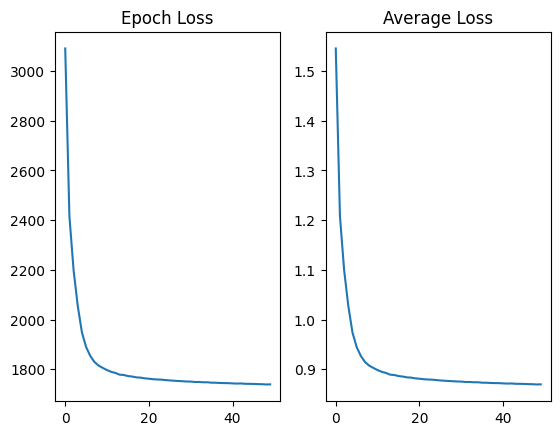

In [9]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(torch.arange(len(losses)), losses)
axs[1].plot(torch.arange(len(losses)), avg_losses)
axs[0].set_title('Epoch Loss')
axs[1].set_title('Average Loss')
plt.show()

## Test evaluation

Looks pretty good to me. The test MSE is slightly lower than the training error. I am conscious of MSE not being the perfect loss function though.

In [14]:
with torch.no_grad():
    model.eval()
    loss = 0
    count = 0
    for tf, _ in test_loader:
        try:
            tf = tf.to(device)
            outputs = model(tf)
            loss += nn.MSELoss()(tf, outputs)
            count += 1
        except:
            print(tf.shape)
    print(f"Average Test Loss: {loss / count:.4f}")
        

torch.Size([10, 1, 28, 28])
Average Test Loss: 0.8613


## Inner workings

In [15]:
# Loads the model and retrieves encoded and decoded images
f, _ = next(iter(test_loader))
f = f.to(device)
f_encoded = model(f, encode = True).cpu().detach()
images = model(f).cpu().detach()
f = f.cpu().detach()
plt.show()

I'd say that this plot is very interesting. The recreated image is surprisingly decent, especially considering what the encoding looks like.

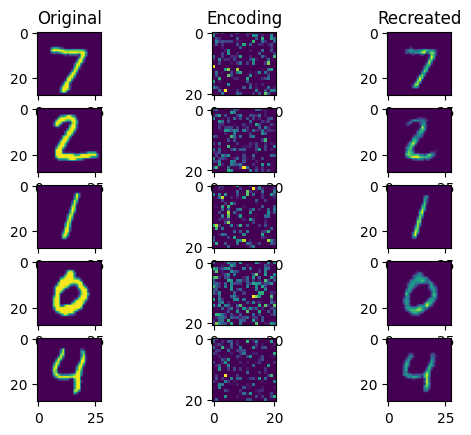

In [18]:
n_examples = 5
fig, axs = plt.subplots(n_examples, 3)

axs[0, 0].set_title('Original')
axs[0, 1].set_title('Encoding')
axs[0, 2].set_title('Recreated')

for i in range(n_examples):
    axs[i, 0].imshow(f[i, 0])
    axs[i, 1].imshow(f_encoded[i, 0])
    axs[i, 2].imshow(images[i, 0])

# Training a model to predict labels based on the encodings